In [1]:
# .whlファイルをローカルのinputからインストールする
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whlnstall-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
!pip install /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=75ab273255234e81e8a54813bab74c39ffd65ebea500900e86c8c0d43edb2050
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
Processing /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
  Attempting

In [2]:
import numpy as np
import pandas as pd
import torch
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.impute import SimpleImputer # 欠損値の補完
from sklearn.preprocessing import LabelEncoder, StandardScaler # エンコードと標準化
from torch.utils.data import TensorDataset

# efs, efs_timeを生存関数に変換
def transform_target(train):
    kmf = KaplanMeierFitter() # イベントの生存確率推定
    # efs_timeとefsを用いて生存関数フィッティング
    kmf.fit(durations=train['efs_time'], event_observed=train['efs']) 
    # efs_timeにおける生存確率
    train['y'] = kmf.survival_function_at_times(train['efs_time']).values

    naf = NelsonAalenFitter() # 累積ハザード関数推定
    # efs_timeとefsを用いて生存関数フィッティング
    naf.fit(durations=train['efs_time'], event_observed=train['efs'])
    # efs_timeにおける生存確率
    train['y'] = naf.cumulative_hazard_at_times(train['efs_time']).values
    train['y'] = train['y'] * 1
    train['y'] = np.log(1 + train.efs_time) # スケール縮小
    return train

# df: データセット
# cat_cols: カテゴリ列のリストとして指定
# transformers: すでに学習されたカテゴリ変数変換エンコーダー
def get_X_cat(df, cat_cols, transformers=None):
    # カテゴリカル列に対してラベルエンコードを適用
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]

    # le.transformでラベルエンコード適用。T(転置)で変数名が列、サンプルが行になる
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T

# カテゴリ列と数値列に分類する
def get_feature_types(train):
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") |\
                                                                       (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"] # 除外する列名
    FEATURES = [c for c in train.columns if not c in RMV]
    print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")
    # 数値列
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical

# 訓練データ、検証データのカテゴリ列、数値列、ラベルエンコードを返す
def get_categoricals(train, val):
    categorical_cols, numerical = get_feature_types(train)
    remove = [] # 削除する列名
    for col in categorical_cols:
        if train[col].nunique() == 1: # ユニーク数が1の場合は削除
            remove.append(col)
        # valの列に訓練データが無い場合、nanに置き換える
        ind = ~val[col].isin(train[col]) # trainに無い列がvalにある場合
        if ind.any():
            val.loc[ind, col] = np.nan
    # colが除外列で無い場合
    categorical_cols = [col for col in categorical_cols if col not in remove]
    # 訓練データに関してラベルエンコードとカテゴリ列を取得
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    # 検証データに関してカテゴリ列を取得
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers

# データセットのテンソル化、データローダーの作成
def init_dl(X_cat, X_num, df, training=False):
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long), # カテゴリdf
        torch.tensor(X_num, dtype=torch.float32), # 数値df
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
    bs = 2048
    # if not training:
    #     bs = 2048 * 8
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train

# 訓練、検証データの取得
def preprocess_data(train, val):
    # カテゴリデータ(訓練、検証)、数値列、ラベルエンコード取得
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler() # 標準化
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True) # 平均で補完
    # 標準化を実施
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    # データローダー作成
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers

In [3]:
# 特徴量の追加
def add_features(df):

    #######################################################################################################
    # # 重症度を加える
    df["intense"] = df["conditioning_intensity"]
    df["intense"] = df.intense.fillna("NA")
    df.loc[df.intense =="N/A, F(pre-TED) not submitted","intense"] = "NA"
    df.loc[df.intense =="N/A","intense"] = "NA"
    df.loc[df.intense =="No drugs reported","intense"] = "NA"
    df.loc[df.intense =="TBD","intense"] = "NA"

    # リスク指数を加える
    df["dri"] = df["dri_score"]
    df["dri"] = df.dri.fillna("Intermediate")
    df.loc[df.dri == "Very high","dri"] = "High"
    df.loc[df.dri == "Missing disease status","dri"] = "High"
    df.loc[df.dri == "Intermediate","dri"] = "Low"
    df.loc[df.dri == "Intermediate - TED AML case <missing cytogenetics","dri"] = "Low"
    df.loc[df.dri == "NA","dri"] = "Intermediate"
    df.loc[df.dri == "N/A - disease not classifiable","dri"] = "Intermediate"
    df.loc[df.dri == "N/A - pediatric","dri"] = "Intermediate"
    df.loc[df.dri == "N/A - non-malignant indication","dri"] = "Intermediate"
    df.loc[df.dri == "TBD cytogenetics","dri"] = "Intermediate"
    df.loc[df.dri == "High - TED AML case <missing cytogenetics","dri"] = "Intermediate"    

    # 細胞遺伝的な指標を加える
    df["cyto"] = df["cyto_score_detail"]
    df["cyto"] = df.cyto.fillna("Intermediate")
    df.loc[df.cyto == "TBD","cyto"] = "Poor"
    df.loc[df.cyto == "Not tested","cyto"] = "Poor"    

    # 肺病の既往歴 (pulm_severe)
    df["pulm"] = df["pulm_severe"]
    df["pulm"] = df.pulm.fillna("Yes")
    df.loc[df.pulm == "Not done","pulm"] = "Yes"
    #######################################################################################################

    # 性一致の列を追加
    sex_match = df.sex_match.astype(str) # 文字列結合
    sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1] # ハイフン取り除き一致確認
    df['sex_match_bool'] = sex_match # 列追加
    df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan # 欠損はnanで埋める

    # 発病が16歳以上かどうか
    df['big_age'] = df.age_at_hct > 16

    # 0.044歳は異常値として加える
    df['strange_age'] = df.age_at_hct == 0.044
    
    # 手術を受けた年が2019の場合2020とする
    df.loc[df.year_hct == 2019, 'year_hct'] = 2020

    # 遺伝子数とその詳細の数字を加える
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)

    # 年齢を等間隔に分ける
    # df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])

    # 発病年齢 / ドナー年齢
    df['age_ts'] = df.age_at_hct / df.donor_age
    
    return df

In [4]:
# 訓練、テストデータの読み込み
def load_data():
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train

In [5]:
import functools
from typing import List
import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm

class CatEmbeddings(nn.Module):
    def __init__(
        self,
        projection_dim: int,                # 出力次元数
        categorical_cardinality: List[int], # 各カテゴリのユニーク数
        embedding_dim: int                  # 埋め込み次元数
    ):
        super(CatEmbeddings, self).__init__()
        # ユニーク数 → 埋め込み次元数
        self.embeddings = nn.ModuleList([nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality])
        # MLP
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim))
        
    def forward(self, x_cat):
        # ユニーク数 -> 埋め込み次元数
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        # 列方向に結合
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat) # MLP

class NN(nn.Module):
    def __init__(
            self,
            continuous_dim: int,                # 数値列の次元数
            categorical_cardinality: List[int], # ユニーク数
            embedding_dim: int,                 # 埋め込み次元数
            projection_dim: int,                # 出力次元数
            hidden_dim: int,                    # 隠れ層の次元数
            dropout: float = 0                  # ドロップアウト確率
    ):
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim), # 中間層に変換
            nn.BatchNorm1d(hidden_dim),                        # バッチ正規化
            nn.Dropout(dropout))                               # ドロップアウト
        self.out = nn.Linear(hidden_dim, 1)                    # 最終出力
        self.dropout = nn.Dropout(dropout)                     # ドロップアウト

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Heの初期値
                nn.init.zeros_(m.bias) # 重みゼロ

    def forward(self, x_cat, x_cont):
        x = self.embeddings(x_cat)        # 埋め込み処理
        x = torch.cat([x, x_cont], dim=1) # カテゴリ列と数値列の結合
        x = self.dropout(x)               # ドロップアウト
        x = self.mlp(x)                   # ニューラルネット
        return self.out(x), x

# 関数の戻り値をキャッシュ
@functools.lru_cache

# 0からN-1まで、2つの要素の全組み合わせ
def combinations(N):
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()

# 生存分析を行うモデル
class LitNN(pl.LightningModule):
    def __init__(
            self,
            continuous_dim: int,                 # 数値列の次元数
            categorical_cardinality: List[int],  # ユニーク数
            embedding_dim: int,                  # 埋め込み次元数
            projection_dim: int,                 # 出力次元数
            hidden_dim: int,                     # 中間次元数
            lr: float = 1e-3,                    # 学習率
            dropout: float = 0.2,                # ドロップアウト
            weight_decay: float = 1e-3,          # 減衰率
            aux_weight: float = 0.1,             # 補助損失の重み
            margin: float = 0.5,                 # 損失関数のマージンパラメータ
            race_index: int = 0                  # 人種カテゴリインデックス
    ):
        super(LitNN, self).__init__()
        self.save_hyperparameters()
        # 各パラメータ入力
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout)
        self.targets = []
        # 隠れ層 -> 隠れ層//2 -> 出力
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1))

    # L2ノルム
    def on_before_optimizer_step(self, optimizer):
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    # MLP処理
    def forward(self, x_cat, x_cont):
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    # 訓練ステップ
    def training_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        # 予測、埋め込みベクトル計算
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    # 基本損失 + 人種の補正損失
    def get_full_loss(self, efs, x_cat, y, y_hat):
        # 予測値と実測値の差異
        loss = self.calc_loss(y, y_hat, efs)
        # 人種に対する損失STD
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        # 基本損失に重み0.1掛けて加算
        loss += 0.1 * race_loss
        return loss, race_loss

    # 人種ごとの損失のSTDを返す
    def get_race_losses(self, efs, x_cat, y, y_hat):
        # 人種のユニーク名
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        # 人種ごとの損失計算
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        # 人種ごとの平均損失
        race_loss = sum(race_losses) / len(race_losses)
        # 人種ごとの損失STD
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    # 予測の順序がどれだけ正しいか
    def calc_loss(self, y, y_hat, efs):
        N = y.shape[0]
        # indexペアを生成
        comb = combinations(N)
        # いずれかが死亡者のペア
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        # 予測値
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        # ターゲット値
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        # T:左が大、F:左が小
        y = 2 * (y_left > y_right).int() - 1
        # 予測値の差がターゲット値の差と同じ順序か。ペナルティを与える
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        # どのペアが損失に含まれるべきか
        mask = self.get_mask(comb, efs, y_left, y_right)
        # (損失 x マスク) / マスク合計
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    # 損失計算に使うペアを選別する
    def get_mask(self, comb, efs, y_left, y_right):
        # 左が長生き
        left_outlived = y_left >= y_right
        # 左が死亡、右が未
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        # 左が長生き、左が死、右が未
        mask2 = (left_outlived & left_1_right_0)
        # 右が長生き
        right_outlived = y_right >= y_left
        # 右が死亡、左が未
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    # C-indexと人種ごとのC-index
    def _calc_cindex(self):
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy() # 実際の値
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy() # 予測値
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy() # フラグ
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy() # 人種
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    # 各人種ごとにC-indexを計算する
    def _metric(self, efs, races, y, y_hat):
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    # 検証ステップの損失計算
    def validation_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    # 損失計算
    def test_step(self, batch, batch_idx):
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    # C-indexと評価指標の出力
    def on_validation_epoch_end(self):
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()
    
    # C-indexと評価指標の出力
    def on_test_epoch_end(self) -> None:
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    # 最適化設定
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, \
                                     weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            # コサイン類似の学習率減衰スケジューラ
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45, # 学習率減衰までのエポック数
                eta_min=6e-3 # 学習率の最小値
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [6]:
import json
import pytorch_lightning as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold

# 乱数固定
pl.seed_everything(42)

# REPEATS = 1 # 繰り返し計算数
FOLDS = 5   # 分割数

# 層状K分割
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True,)

test, train_original = load_data()
oof_nn = np.zeros(train_original.shape[0]) # 検証結果
pred_nn = np.zeros(test.shape[0]) # テスト結果

# データ読み込み
test, train_original = load_data()
test['efs_time'] = 1
test['efs'] = 1
# カテゴリと数値列に分解
categorical_cols, numerical = get_feature_types(train_original)

# 全結合層での計算
def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.06464861983337984,
            "dropout": 0.05463240181423116,
            "aux_weight": 0.26545778308743806,
            "margin": 0.2588153271003354,
            "weight_decay": 0.0002773544957610778
        }
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=60,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()

for i, (train_index, test_index) in enumerate(
    kf.split(train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str))):

    # 訓練、検証データに分解
    tt = train_original.copy()
    train = tt.iloc[train_index]
    val = tt.iloc[test_index]
    
    # 検証データの前処理
    X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
    # 学習
    model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)

    # 予測
    pred, _ = model.cuda().eval()(
        torch.tensor(X_cat_val, dtype=torch.long).cuda(),
        torch.tensor(X_num_val, dtype=torch.float32).cuda())
    oof_nn[test_index] += pred.detach().cpu().numpy()

    # テストデータの前処理
    X_cat_test, X_num_train, X_num_test, dl_train, dl_test, transformers = preprocess_data(train, test)
    # 予測
    pred, _ = model.cuda().eval()(
        torch.tensor(X_cat_test, dtype=torch.long).cuda(),
        torch.tensor(X_num_test, dtype=torch.float32).cuda())
    pred_nn += pred.detach().cpu().numpy()

# 平均
# oof_nn /= -FOLDS
pred_nn /= FOLDS

<ipython-input-3-29e200d6e389>:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan # 欠損はnanで埋める


Test shape: (3, 67)


<ipython-input-3-29e200d6e389>:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan # 欠損はnanで埋める
<ipython-input-3-29e200d6e389>:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan # 欠損はnanで埋める


Train shape: (28800, 69)
Test shape: (3, 67)


<ipython-input-3-29e200d6e389>:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan # 欠損はnanで埋める


Train shape: (28800, 69)
There are 66 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'intense', 'dri

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['lr-Adam', 'train_loss', 'train_loss_step', 'grad_2.0_norm/embeddings.embeddings.0.weight', 'grad_2.0_norm/embeddings.embeddings.1.weight', 'grad_2.0_norm/embeddings.embeddings.2.weight', 'grad_2.0_norm/embeddings.embeddings.3.weight', 'grad_2.0_norm/embeddings.embeddings.4.weight', 'grad_2.0_norm/embeddings.embeddings.5.weight', 'grad_2.0_norm/embeddings.embeddings.6.weight', 'grad_2.0_norm/embeddings.embeddings.7.weight', 'grad_2.0_norm/embeddings.embeddings.8.weight', 'grad_2.0_norm/embeddings.embeddings.9.weight', 'grad_2.0_norm/embeddings.embeddings.10.weight', 'grad_2.0_norm/embeddings.embeddings.11.weight', 'grad_2.0_norm/embeddings.embeddings.12.weight', 'grad_2.0_norm/embeddings.embeddings.13.weight', 'grad_2.0_norm/embeddings.embeddings.14.weight', 'grad_2.0_norm/embeddings.embeddings.15.w

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6791220307350159     │
│    test_cindex_simple     │    0.6936557292938232     │
│         test_loss         │    0.18122273312553697    │
└───────────────────────────┴───────────────────────────┘

There are 66 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'intense', 'dri', 'cyto', 'pulm', 'sex_m

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6774696111679077     │
│    test_cindex_simple     │    0.6856346130371094     │
│         test_loss         │    0.18564334341426666    │
└───────────────────────────┴───────────────────────────┘

There are 66 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'intense', 'dri', 'cyto', 'pulm', 'sex_m

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6851228475570679     │
│    test_cindex_simple     │    0.6916414499282837     │
│         test_loss         │    0.1824728882957622     │
└───────────────────────────┴───────────────────────────┘

There are 66 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'intense', 'dri', 'cyto', 'pulm', 'sex_m

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6833794116973877     │
│    test_cindex_simple     │     0.697417676448822     │
│         test_loss         │    0.1794500231727324     │
└───────────────────────────┴───────────────────────────┘

There are 66 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'intense', 'dri', 'cyto', 'pulm', 'sex_m

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6706233620643616     │
│    test_cindex_simple     │    0.6793246865272522     │
│         test_loss         │    0.18945488715342737    │
└───────────────────────────┴───────────────────────────┘

There are 66 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'intense', 'dri', 'cyto', 'pulm', 'sex_m

In [7]:
# スコアへの換算
from metric import score

y_true = train_original[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_original[["ID"]].copy()
y_pred["prediction"] = oof_nn
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for NN =",m)


Overall CV for NN = 0.30575617173707237


### 機械学習パート

In [8]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
# train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")

In [9]:
def load_data():
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train

test, train = load_data()

Test shape: (3, 67)


<ipython-input-3-29e200d6e389>:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan # 欠損はnanで埋める


Train shape: (28800, 69)


<ipython-input-3-29e200d6e389>:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan # 欠損はnanで埋める


In [10]:
# plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
# plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
# plt.xlabel("Time of Observation, efs_time")
# plt.ylabel("Density")
# plt.title("Times of Observation. Either time to event, or time observed without event.")
# plt.legend()
# plt.show()

In [11]:
# # カプランマイヤーに変換
# from lifelines import KaplanMeierFitter
# def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
#     kmf = KaplanMeierFitter()
#     # kmf.fit(生存期間,死亡フラグ)
#     kmf.fit(df[time_col], df[event_col])
#     y = kmf.survival_function_at_times(df[time_col]).values
#     return y, kmf
# train["y"], kmf0 = transform_survival_probability(train, time_col='efs_time', event_col='efs')
# # plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
# # plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
# # plt.xlabel("Transformed Target y")
# # plt.ylabel("Density")
# # plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
# # plt.legend()
# # plt.show()

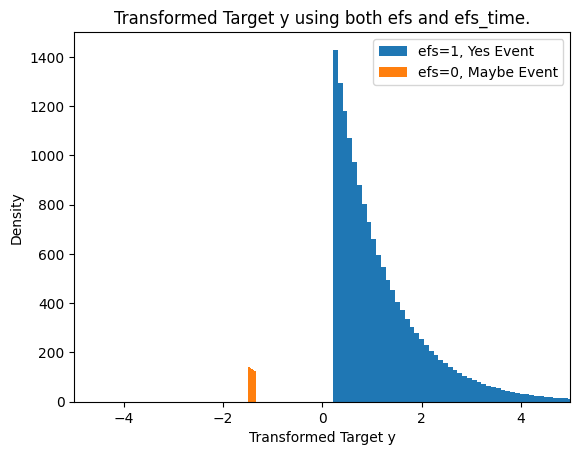

In [12]:
# 死亡者の寿命を最大・最小化して再スケーリング
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()

# 生存者に大きな値を与えることで分離
train.loc[train.efs==0,"y"] += 2*len(train)
# 正規化
train.y = train.y / train.y.max()
# スケール縮小
train.y = np.log(train.y )
# ゼロ平均
train.y -= train.y.mean()
# 反転
train.y *= -1.0

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlim((-5,5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [13]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 66 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'intense', 'dri', 'cyto', 'pulm', 'sex_m

In [14]:
# カテゴリ変数の分類
CATS = []
for c in FEATURES:
    # オブジェクト場合、欠損はNANを加える
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 40 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'intense', 'dri', 'cyto', 'pulm', 'sex_match_bool']


<ipython-input-14-27867204cea9>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[c] = test[c].fillna("NAN")


In [15]:
# データ結合
combined = pd.concat([train,test],axis=0,ignore_index=True)

# カテゴリ変数をラベルエンコードする
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # ラベルエンコード
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize() # ラベルエンコード
        combined[c] -= combined[c].min() # ラベルの最小値で引く
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # メモリを減らす(64bit → 32bit)
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

# 訓練データとテストデータに戻す
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, intense, dri, cyto, pulm, sex_match_bool, 

In [16]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [17]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    # パラメータ
    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        #early_stopping_rounds=25,
    )
    # 訓練
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # 検証データの推論
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # テストデータの推論
    pred_xgb += model_xgb.predict(x_test)

# 推論結果の平均
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:1.49102
[500]	validation_0-rmse:1.34195
[1000]	validation_0-rmse:1.32913
[1500]	validation_0-rmse:1.32408
[1999]	validation_0-rmse:1.32222
#########################
### Fold 2
#########################


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:54:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.50579
[500]	validation_0-rmse:1.36750
[1000]	validation_0-rmse:1.35765
[1500]	validation_0-rmse:1.35405
[1999]	validation_0-rmse:1.35216
#########################
### Fold 3
#########################
[0]	validation_0-rmse:1.50996
[500]	validation_0-rmse:1.35168
[1000]	validation_0-rmse:1.34156
[1500]	validation_0-rmse:1.33900
[1999]	validation_0-rmse:1.33732
#########################
### Fold 4
#########################
[0]	validation_0-rmse:1.51228
[500]	validation_0-rmse:1.34954
[1000]	validation_0-rmse:1.33641
[1500]	validation_0-rmse:1.33077
[1999]	validation_0-rmse:1.32867
#########################
### Fold 5
#########################
[0]	validation_0-rmse:1.48203
[500]	validation_0-rmse:1.35163
[1000]	validation_0-rmse:1.34263
[1500]	validation_0-rmse:1.33836
[1999]	validation_0-rmse:1.33563
#########################
### Fold 6
#########################
[0]	validation_0-rmse:1.51507
[500]	validation_0-rmse:1.36826
[1000]	validation_0-rmse:1.35881
[1500]	va

In [18]:
# スコアへの換算
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier = 0.6747641969972192


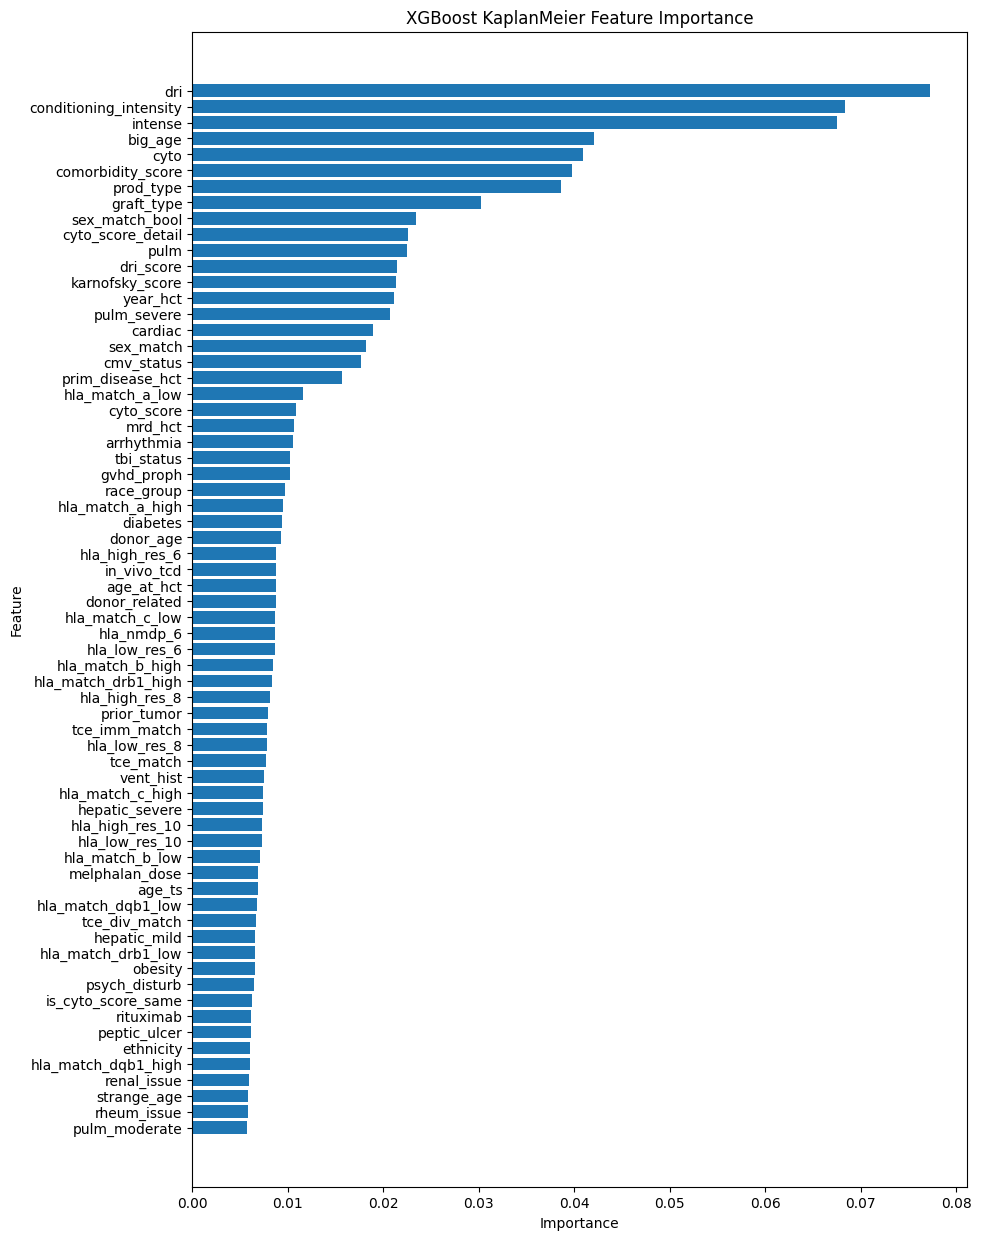

In [19]:
# 特徴量の寄与度
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [20]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [21]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",  
        learning_rate=0.1,    
        grow_policy='Lossguide',
        #early_stopping_rounds=25,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 1.4860792	test: 1.4762206	best: 1.4762206 (0)	total: 103ms	remaining: 1m 43s
250:	learn: 1.2365208	test: 1.3297881	best: 1.3296955 (249)	total: 5.83s	remaining: 17.4s
500:	learn: 1.1649386	test: 1.3266011	best: 1.3261410 (488)	total: 11.6s	remaining: 11.6s
750:	learn: 1.1050027	test: 1.3290814	best: 1.3261410 (488)	total: 17.4s	remaining: 5.76s
999:	learn: 1.0542526	test: 1.3316380	best: 1.3261410 (488)	total: 23s	remaining: 0us
bestTest = 1.326140969
bestIteration = 488
Shrink model to first 489 iterations.
#########################
### Fold 2
#########################
0:	learn: 1.4846839	test: 1.4906154	best: 1.4906154 (0)	total: 23.7ms	remaining: 23.6s
250:	learn: 1.2364450	test: 1.3583781	best: 1.3580918 (248)	total: 5.68s	remaining: 16.9s
500:	learn: 1.1658300	test: 1.3568849	best: 1.3561179 (444)	total: 11.9s	remaining: 11.8s
750:	learn: 1.1094469	test: 1.3608260	best: 1.3561179 (444)	total: 17.9s	remaining:

In [22]:
# スコア換算
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier = 0.6735067175834067


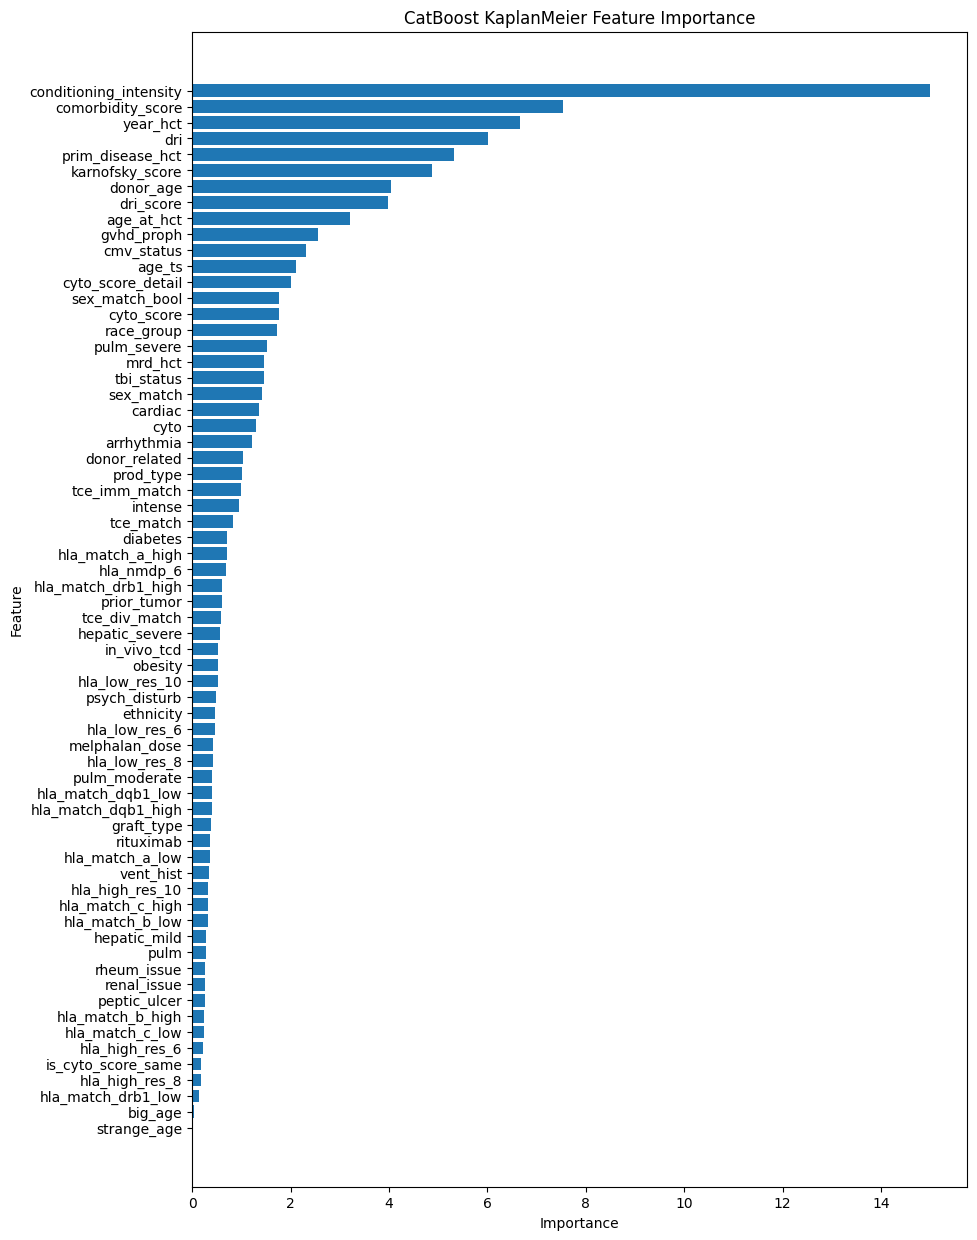

In [23]:
# 特徴量の寄与度
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [24]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
print("Using LightGBM version",lgb.__version__)

Using LightGBM version 4.5.0


In [25]:
# LightGBMのベースライン
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_lgb = LGBMRegressor(
        device="gpu", 
        max_depth=3, 
        colsample_bytree=0.4,  
        #subsample=0.9, 
        n_estimators=2500, 
        learning_rate=0.02, 
        objective="regression", 
        verbose=-1, 
        #early_stopping_rounds=25,
    )
    model_lgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
    )
    
    # INFER OOF
    oof_lgb[test_index] = model_lgb.predict(x_valid)
    # INFER TEST
    pred_lgb += model_lgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_lgb /= FOLDS

#########################
### Fold 1
#########################
#########################
### Fold 2
#########################
#########################
### Fold 3
#########################
#########################
### Fold 4
#########################
#########################
### Fold 5
#########################
#########################
### Fold 6
#########################
#########################
### Fold 7
#########################
#########################
### Fold 8
#########################
#########################
### Fold 9
#########################
#########################
### Fold 10
#########################


In [26]:
# スコアの換算
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for LightGBM KaplanMeier = 0.6734751833881338


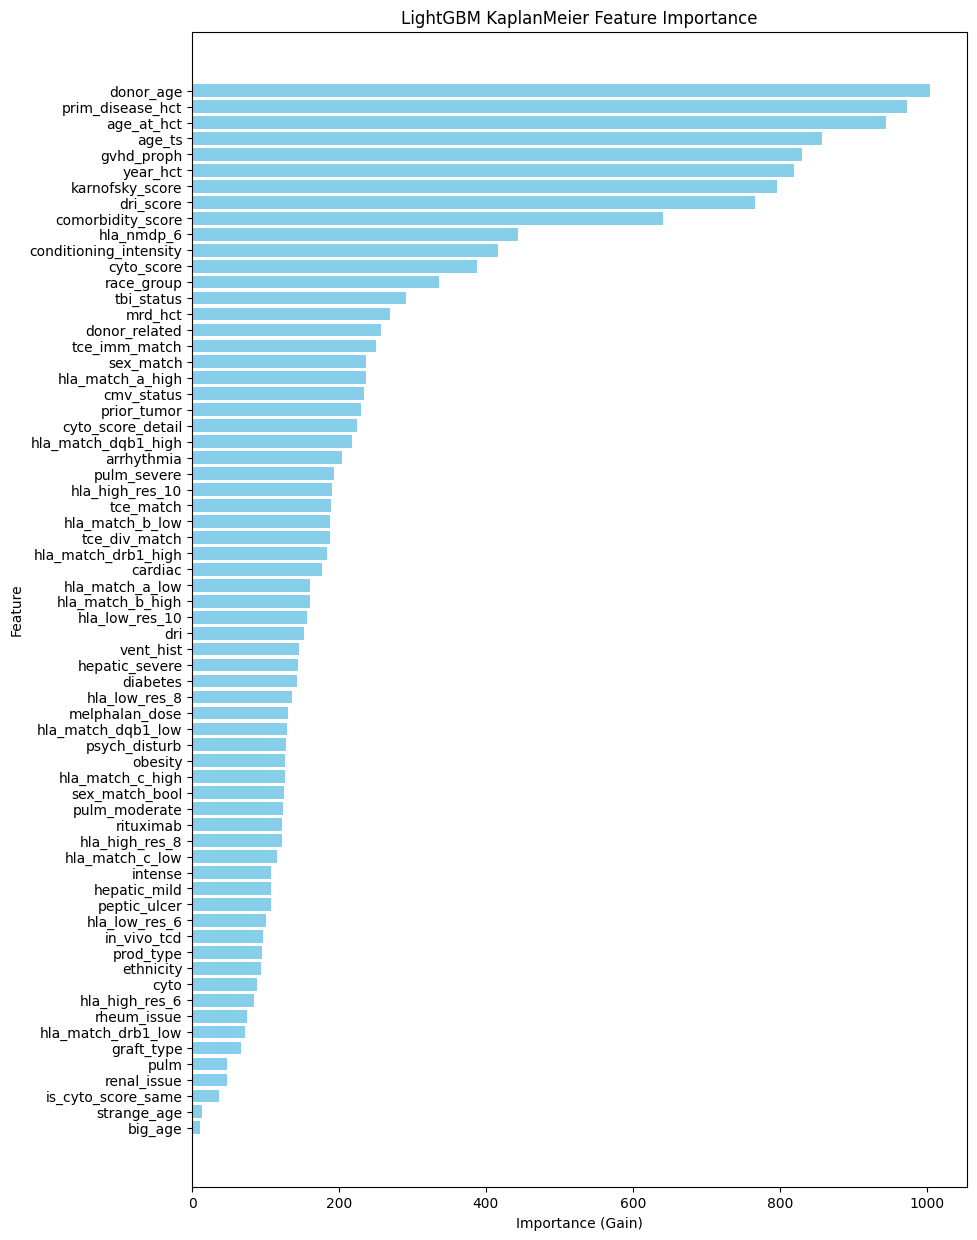

In [27]:
# 特徴量の寄与度
feature_importance = model_lgb.feature_importances_ 
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM KaplanMeier Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

In [28]:
# # SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
# train["efs_time2"] = train.efs_time.copy()
# train.loc[train.efs==0,"efs_time2"] *= -1

In [29]:
# FOLDS = 10
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
# oof_xgb_cox = np.zeros(len(train))
# pred_xgb_cox = np.zeros(len(test))

# for i, (train_index, test_index) in enumerate(kf.split(train)):

#     print("#"*25)
#     print(f"### Fold {i+1}")
#     print("#"*25)
    
#     x_train = train.loc[train_index,FEATURES].copy()
#     y_train = train.loc[train_index,"efs_time2"]    
#     x_valid = train.loc[test_index,FEATURES].copy()
#     y_valid = train.loc[test_index,"efs_time2"]
#     x_test = test[FEATURES].copy()

#     model_xgb_cox = XGBRegressor(
#         device="cuda",
#         max_depth=3,  
#         colsample_bytree=0.5,  
#         subsample=0.8,  
#         n_estimators=2000,  
#         learning_rate=0.02,  
#         enable_categorical=True,
#         min_child_weight=80,
#         objective='survival:cox',
#         eval_metric='cox-nloglik',
#     )
#     model_xgb_cox.fit(
#         x_train, y_train,
#         eval_set=[(x_valid, y_valid)],  
#         verbose=500  
#     )
    
#     # INFER OOF
#     oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
#     # INFER TEST
#     pred_xgb_cox += model_xgb_cox.predict(x_test)

# # COMPUTE AVERAGE TEST PREDS
# pred_xgb_cox /= FOLDS

In [30]:
# y_true = train[["ID","efs","efs_time","race_group"]].copy()
# y_pred = train[["ID"]].copy()
# y_pred["prediction"] = oof_xgb_cox
# m = score(y_true.copy(), y_pred.copy(), "ID")
# print(f"\nOverall CV for XGBoost Survival:Cox =",m)

In [31]:
# feature_importance = model_xgb_cox.feature_importances_
# importance_df = pd.DataFrame({
#     "Feature": FEATURES,  # Replace FEATURES with your list of feature names
#     "Importance": feature_importance
# }).sort_values(by="Importance", ascending=False)
# plt.figure(figsize=(10, 15))
# plt.barh(importance_df["Feature"], importance_df["Importance"])
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("XGBoost Survival:Cox Feature Importance")
# plt.gca().invert_yaxis()  # Flip features for better readability
# plt.show()

In [32]:
# FOLDS = 10
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
# oof_cat_cox = np.zeros(len(train))
# pred_cat_cox = np.zeros(len(test))

# for i, (train_index, test_index) in enumerate(kf.split(train)):

#     print("#"*25)
#     print(f"### Fold {i+1}")
#     print("#"*25)
    
#     x_train = train.loc[train_index,FEATURES].copy()
#     y_train = train.loc[train_index,"efs_time2"]    
#     x_valid = train.loc[test_index,FEATURES].copy()
#     y_valid = train.loc[test_index,"efs_time2"]
#     x_test = test[FEATURES].copy()

#     model_cat_cox = CatBoostRegressor(
#         loss_function="Cox",
#         #task_type="GPU",   
#         iterations=400,     
#         learning_rate=0.1,  
#         grow_policy='Lossguide',
#         use_best_model=False,
#     )
#     model_cat_cox.fit(x_train,y_train,
#               eval_set=(x_valid, y_valid),
#               cat_features=CATS,
#               verbose=100)
    
#     # INFER OOF
#     oof_cat_cox[test_index] = model_cat_cox.predict(x_valid)
#     # INFER TEST
#     pred_cat_cox += model_cat_cox.predict(x_test)

# # COMPUTE AVERAGE TEST PREDS
# pred_cat_cox /= FOLDS

In [33]:
# y_true = train[["ID","efs","efs_time","race_group"]].copy()
# y_pred = train[["ID"]].copy()
# y_pred["prediction"] = oof_cat_cox
# m = score(y_true.copy(), y_pred.copy(), "ID")
# print(f"\nOverall CV for CatBoost Survival:Cox =",m)

In [34]:
# feature_importance = model_cat_cox.get_feature_importance()
# importance_df = pd.DataFrame({
#     "Feature": FEATURES, 
#     "Importance": feature_importance
# }).sort_values(by="Importance", ascending=False)
# plt.figure(figsize=(10, 15))
# plt.barh(importance_df["Feature"], importance_df["Importance"])
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("CatBoost Survival:Cox Feature Importance")
# plt.gca().invert_yaxis()  # Flip features for better readability
# plt.show()

In [35]:
from scipy.stats import rankdata 

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb) + rankdata(oof_cat) + rankdata(oof_lgb)
# y_pred["prediction"] = rankdata(oof_xgb) + rankdata(oof_cat) + rankdata(oof_lgb)\
#                      + rankdata(oof_xgb_cox) + rankdata(oof_cat_cox)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6760525672515229


In [36]:
from scipy.stats import rankdata 

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb) + rankdata(oof_cat) + rankdata(oof_lgb)\
                     + rankdata(-oof_nn)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6804967771128374


In [37]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_xgb) + rankdata(pred_cat) + rankdata(pred_lgb)\
                     + rankdata(-pred_nn)
# sub.prediction = rankdata(pred_xgb) + rankdata(pred_cat) + rankdata(pred_lgb)\
#                      + rankdata(pred_xgb_cox) + rankdata(pred_cat_cox) + rankdata(-pred_nn)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,8.0
1,28801,12.0
2,28802,4.0
